In [1]:
import os, sys
cur_dir = os.getcwd()
basename = os.path.basename(cur_dir)
for _ in range(5):
    if basename != 'OCLog':
        cur_dir = os.path.dirname(cur_dir)
        basename = os.path.basename(cur_dir)
        #print(cur_dir, basename)
    else:
        if cur_dir not in sys.path:
            sys.path.append(cur_dir)
            #print(sys.path)
import os
from openpyxl import Workbook
from openpyxl import load_workbook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tqdm import trange, tqdm, tnrange
from oclog.BGL.bglogUKC import BGLog, get_embedding_layer
from oclog.openset.boundary_loss import euclidean_metric, BoundaryLoss
from oclog.openset.pretraining import LogLineEncoder, LogSeqEncoder, LogClassifier
# from oclog.openset.openset import OpenSet
from oclog.openset.opensetv6 import OpenSet
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import sklearn.metrics as m
import warnings
warnings.filterwarnings('ignore')
def update_tracker(file_name, data):
    if os.path.exists(file_name):
        wb = load_workbook(file_name)
    else:
        wb = Workbook()    
    wb.save(file_name)
    # wb.close(file_name)
    orig_df = pd.read_excel(file_name,)
    #print(orig_df.head())
    new_df = pd.DataFrame(data, )
    concat_df = pd.concat([orig_df, new_df], axis=0)
    #print(concat_df.head())
    concat_df.to_excel(file_name)
    return concat_df

def oset_train(ablation=5000,designated_ukc_cls=3,num_classes=2,embedding_size=128,lr_rate=3,optimizer='sgd',
pretrain_epochs=3,octrain_epochs=200,wait_patience=3, debug=False, tracker='tracker.xlsx', comment='',
             tracker_update=True):
    tf.random.set_seed(1234)
    np.random.seed(1234) 
    bglog = BGLog(save_padded_num_sequences=False, debug=debug,  load_from_pkl=True, )
    train_test = bglog.get_tensor_train_val_test(ablation=ablation, designated_ukc_cls=designated_ukc_cls )
    train_data, val_data, test_data = train_test
    line_encoder = LogLineEncoder(bglog, chars_in_line=64)
    logSeqencer =  LogSeqEncoder(line_in_seq=32, dense_neurons=embedding_size)
    ptmodel = LogClassifier(line_encoder=line_encoder, seq_encoder=logSeqencer, num_classes=num_classes)
    ptmodel.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    hist = ptmodel.fit(train_data, validation_data=val_data, epochs=pretrain_epochs)    
    pre_tr_acc = hist.history.get('accuracy')[len(hist.history.get('accuracy'))-1]
    # print(round(pre_tr_acc, 4))
    pre_val_acc = hist.history.get('val_accuracy')[len(hist.history.get('val_accuracy'))-1]
    # print(round(pre_val_acc, 4))
    oset = OpenSet(num_classes, ptmodel, embedding_size=embedding_size)
    _, _ = oset.train(train_data,data_val=val_data, epochs=octrain_epochs, 
                      lr_rate=lr_rate, wait_patience=wait_patience, optimizer=optimizer,
                     pretrain_hist=hist)
    _, _, f1_weighted, f_measure = oset.evaluate(test_data, ukc_label=designated_ukc_cls)
    lst = list(tf.reshape(oset.radius, (1, num_classes)).numpy()[0])
    lst = [str(i) for i in lst]
    radius = ','.join(lst)    
    loss = oset.losses[len(oset.losses)-1].numpy()    
    tracker_data = {'ablation':[ablation],'designated_ukc_cls': [designated_ukc_cls],'num_classes': [num_classes],
                   'embedding_size': [embedding_size], 'lr_rate': [lr_rate], 'optimizer': [optimizer],
                    'pretrain_epochs': [pretrain_epochs],'octrain_epochs': [oset.epoch], 'wait_patience': [wait_patience], 
                   'f1_weighted': [f1_weighted], 'f1_macro': f_measure.get('F1-score'), 
                   'F1Known': f_measure.get('Known'), 'F1Open': f_measure.get('Open'), 'loss':[loss], 'Radius': radius,
                   'pre_tr_acc': pre_tr_acc, 'pre_val_acc': pre_val_acc,'comment': comment}
    
    if tracker_update:
        update_tracker(tracker, tracker_data)
    return test_data, oset, hist

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 2000
val_0:, 250
test_0:, 250
train_1:, 2000
val_1:, 250
test_1:, 250
train_2:, 2000
val_2:, 250
test_2:, 250
class 5 is added as ukc
ukc_5:, 165
vocab_size: 50
Epoch 1/3
187/187 [==============================] - 18s 94ms/step - loss: 0.0672 - accuracy: 0.9793 - precision: 0.9882 - recall: 0.9662 - val_loss: 8.5805e-04 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/3
187/187 [==============================] - 18s 94ms/step - loss: 0.0021 - accuracy: 0.9992 - precision: 0.9993 - recall: 0.9992 - val_loss: 2.3739e-05 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/3
187/187 [==============================] - 17s 93ms/step - loss: 5.0672e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.1871e-05 - val_accuracy: 1.0000

100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.55it/s]


epoch: 1/500, train_loss: 2.5720136165618896, F1_train: 0.6552732809996292 F1_val: 0.6698369565217391
self.best_train_score: 0.6552732809996292
self.best_val_score: 0.6698369565217391


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.57it/s]


epoch: 2/500, train_loss: 2.573251247406006, F1_train: 0.9374195376681653 F1_val: 1.0
self.best_train_score: 0.9374195376681653
self.best_val_score: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.57it/s]


epoch: 3/500, train_loss: 2.5769243240356445, F1_train: 0.9385915063810815 F1_val: 1.0
self.best_train_score: 0.9385915063810815


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.54it/s]


epoch: 4/500, train_loss: 2.577026128768921, F1_train: 0.9402573623045357 F1_val: 1.0
self.best_train_score: 0.9402573623045357


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.45it/s]


epoch: 5/500, train_loss: 2.575432062149048, F1_train: 0.9419900527936462 F1_val: 1.0
self.best_train_score: 0.9419900527936462


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.43it/s]


epoch: 6/500, train_loss: 2.576350688934326, F1_train: 0.9486258017495568 F1_val: 1.0
self.best_train_score: 0.9486258017495568


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.55it/s]


epoch: 7/500, train_loss: 2.575076103210449, F1_train: 0.9501769294156156 F1_val: 1.0
self.best_train_score: 0.9501769294156156


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.52it/s]


epoch: 8/500, train_loss: 2.574291706085205, F1_train: 0.9516025922110007 F1_val: 1.0
self.best_train_score: 0.9516025922110007


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.53it/s]


epoch: 9/500, train_loss: 2.573806047439575, F1_train: 0.9528104372066815 F1_val: 1.0
self.best_train_score: 0.9528104372066815


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.41it/s]


epoch: 10/500, train_loss: 2.5722031593322754, F1_train: 0.9540005674382535 F1_val: 1.0
self.best_train_score: 0.9540005674382535


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.52it/s]


epoch: 11/500, train_loss: 2.576481819152832, F1_train: 0.9551535510245112 F1_val: 1.0
self.best_train_score: 0.9551535510245112


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.55it/s]


epoch: 12/500, train_loss: 2.575564384460449, F1_train: 0.9551686728369279 F1_val: 1.0
self.best_train_score: 0.9551686728369279


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.47it/s]


epoch: 13/500, train_loss: 2.575889825820923, F1_train: 0.9559110116092279 F1_val: 1.0
self.best_train_score: 0.9559110116092279


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.45it/s]


epoch: 14/500, train_loss: 2.5728001594543457, F1_train: 0.955922687127903 F1_val: 1.0
self.best_train_score: 0.955922687127903


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.52it/s]


epoch: 15/500, train_loss: 2.572397232055664, F1_train: 0.9559110116092279 F1_val: 1.0
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:26<00:00,  7.11it/s]


epoch: 16/500, train_loss: 2.574638605117798, F1_train: 0.9559168559910944 F1_val: 1.0
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.28it/s]


epoch: 17/500, train_loss: 2.5715370178222656, F1_train: 0.9562378868443743 F1_val: 1.0
self.best_train_score: 0.9562378868443743


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.40it/s]


epoch: 18/500, train_loss: 2.574519634246826, F1_train: 0.9563390444095958 F1_val: 1.0
self.best_train_score: 0.9563390444095958


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.48it/s]


epoch: 19/500, train_loss: 2.575071334838867, F1_train: 0.9570885397363266 F1_val: 1.0
self.best_train_score: 0.9570885397363266


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.53it/s]


epoch: 20/500, train_loss: 2.5719497203826904, F1_train: 0.9568838934530888 F1_val: 1.0
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.67it/s]


epoch: 21/500, train_loss: 2.5754547119140625, F1_train: 0.9568811052449355 F1_val: 1.0
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:23<00:00,  7.85it/s]


epoch: 22/500, train_loss: 2.573491334915161, F1_train: 0.9570774404176187 F1_val: 1.0
train score not improving  going to wait state 3
val score not improving  going to wait state 3


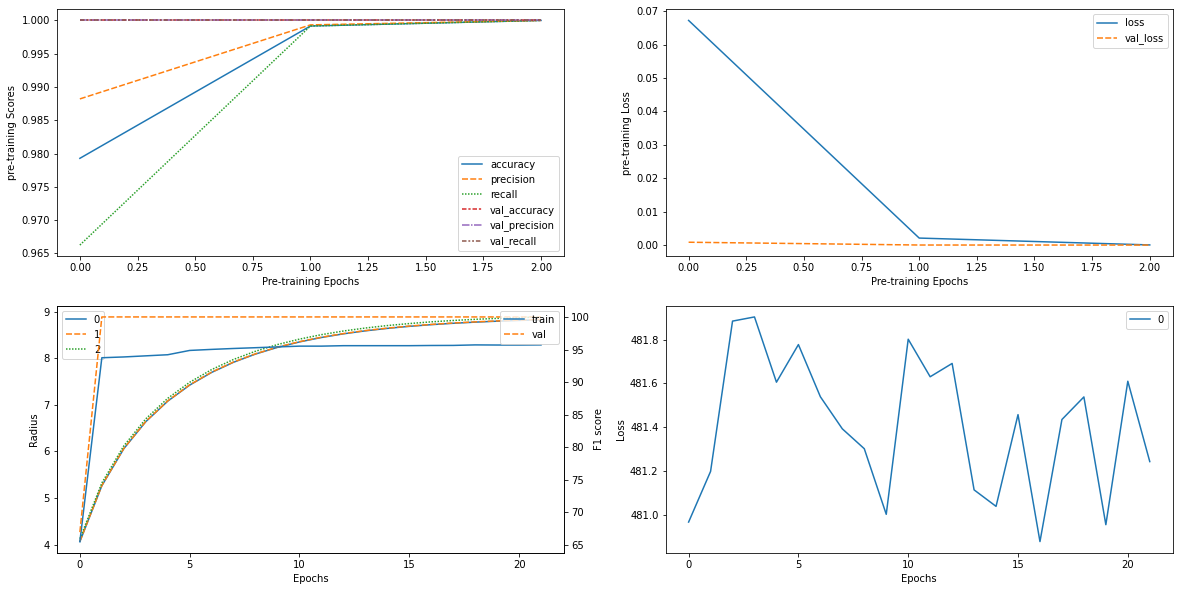

[[243   0   0   0]
 [  0 246   0   0]
 [  0   0 245   0]
 [ 35   0   0 127]]
96.09
f1_weighted: 0.9598842038367792, f1_macro: 0.9529285576712339, f1_micro: 0.9609375, f_measure: {'Known': 97.7607, 'Open': 87.8893, 'F1-score': 95.2929}
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       243
           1       1.00      1.00      1.00       246
           2       1.00      1.00      1.00       245
           5       1.00      0.78      0.88       162

    accuracy                           0.96       896
   macro avg       0.97      0.95      0.95       896
weighted avg       0.97      0.96      0.96       896



In [2]:
b

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 2000
val_0:, 250
test_0:, 250
train_1:, 2000
val_1:, 250
test_1:, 250
train_2:, 2000
val_2:, 250
test_2:, 250
class 5 is added as ukc
ukc_5:, 165
vocab_size: 50
Epoch 1/10
187/187 [==============================] - 19s 96ms/step - loss: 0.0672 - accuracy: 0.9793 - precision: 0.9882 - recall: 0.9662 - val_loss: 8.5805e-04 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/10
187/187 [==============================] - 18s 94ms/step - loss: 0.0021 - accuracy: 0.9992 - precision: 0.9993 - recall: 0.9992 - val_loss: 2.3739e-05 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/10
187/187 [==============================] - 18s 94ms/step - loss: 5.0672e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.1871e-05 - val_accuracy: 1.0

100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.53it/s]


epoch: 1/200, train_loss: 2.8574490547180176, F1_train: 0.6409704035984577 F1_val: 0.6657608695652174


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.55it/s]


epoch: 2/200, train_loss: 2.8639559745788574, F1_train: 0.9337932421461281 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.51it/s]


epoch: 3/200, train_loss: 2.862243890762329, F1_train: 0.9374415506564574 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.53it/s]


epoch: 4/200, train_loss: 2.8618340492248535, F1_train: 0.9380280119244895 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.53it/s]


epoch: 5/200, train_loss: 2.859511137008667, F1_train: 0.9390587196864847 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.54it/s]


epoch: 6/200, train_loss: 2.8616132736206055, F1_train: 0.9399466878352597 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.53it/s]


epoch: 7/200, train_loss: 2.862504005432129, F1_train: 0.9411098247560263 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.52it/s]


epoch: 8/200, train_loss: 2.8561110496520996, F1_train: 0.9416660617595739 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.60it/s]


epoch: 9/200, train_loss: 2.8619492053985596, F1_train: 0.9425953641468329 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.62it/s]


epoch: 10/200, train_loss: 2.857422113418579, F1_train: 0.9436680088551506 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.61it/s]


epoch: 11/200, train_loss: 2.8638691902160645, F1_train: 0.943658483823213 F1_val: 1.0
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.56it/s]


epoch: 12/200, train_loss: 2.86074161529541, F1_train: 0.9491812156581972 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.58it/s]


epoch: 13/200, train_loss: 2.8623366355895996, F1_train: 0.9501657509829674 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.48it/s]


epoch: 14/200, train_loss: 2.861170768737793, F1_train: 0.9502872457006429 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.61it/s]


epoch: 15/200, train_loss: 2.860692024230957, F1_train: 0.9506214657235486 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.59it/s]


epoch: 16/200, train_loss: 2.858339309692383, F1_train: 0.9510504981311966 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.56it/s]


epoch: 17/200, train_loss: 2.8626768589019775, F1_train: 0.9508414951268733 F1_val: 1.0
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.56it/s]


epoch: 18/200, train_loss: 2.863189220428467, F1_train: 0.9510540934771743 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.59it/s]


epoch: 19/200, train_loss: 2.8574018478393555, F1_train: 0.9512807959774431 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.61it/s]


epoch: 20/200, train_loss: 2.862804651260376, F1_train: 0.9512807960405196 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.56it/s]


epoch: 21/200, train_loss: 2.8646399974823, F1_train: 0.9511674943773404 F1_val: 1.0
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.57it/s]


epoch: 22/200, train_loss: 2.8624072074890137, F1_train: 0.9510468986455014 F1_val: 1.0
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.60it/s]


epoch: 23/200, train_loss: 2.8618509769439697, F1_train: 0.9511710653390965 F1_val: 1.0
train score not improving  going to wait state 3
val score not improving  going to wait state 3


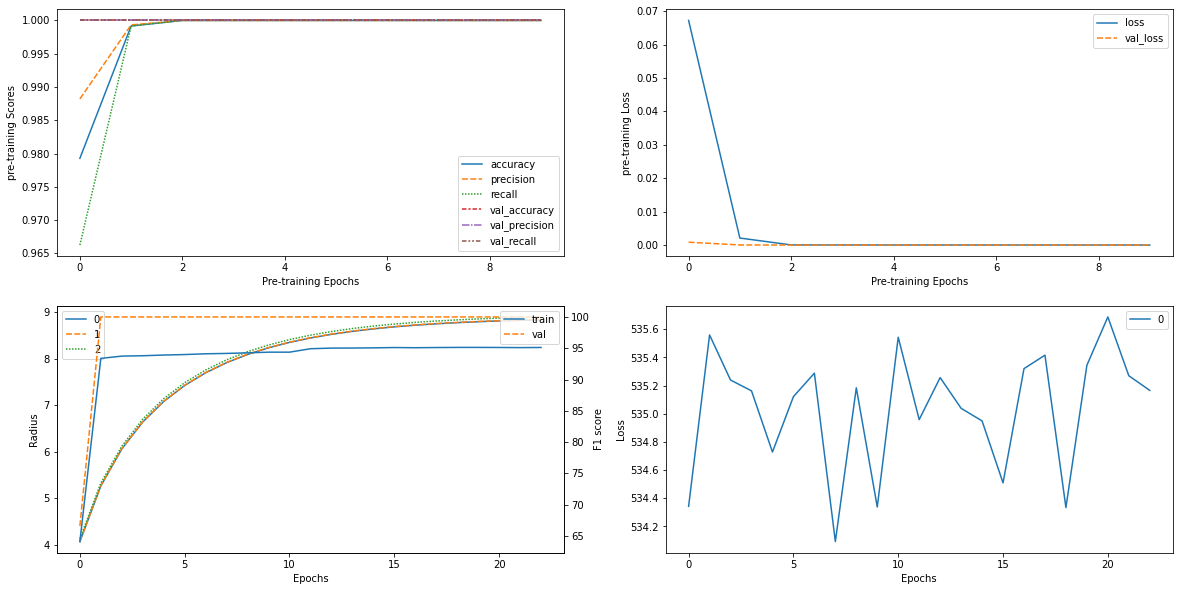

[[243   0   0   0]
 [  0 243   0   3]
 [  0   0 245   0]
 [  1   0   0 161]]
99.55
f1_weighted: 0.9955402836815935, f1_macro: 0.9948854259835478, f1_micro: 0.9955357142857143, f_measure: {'Known': 99.7271, 'Open': 98.773, 'F1-score': 99.4885}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       243
           1       1.00      0.99      0.99       246
           2       1.00      1.00      1.00       245
           5       0.98      0.99      0.99       162

    accuracy                           1.00       896
   macro avg       0.99      1.00      0.99       896
weighted avg       1.00      1.00      1.00       896



In [2]:
comment="after wait logic change, epochs increased to 20, radius increaed to 8.7 but score dropped. lets increase the pretrain"
test_data, oset, hist = oset_train(ablation=2500,designated_ukc_cls=5,num_classes=3,embedding_size=12,
                             lr_rate=2.6, optimizer='adam',
pretrain_epochs=10, wait_patience=3, comment=comment)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 2000
val_0:, 250
test_0:, 250
train_1:, 2000
val_1:, 250
test_1:, 250
train_2:, 2000
val_2:, 250
test_2:, 250
class 5 is added as ukc
ukc_5:, 165
vocab_size: 50
Epoch 1/10
187/187 [==============================] - 19s 98ms/step - loss: 0.0672 - accuracy: 0.9793 - precision_1: 0.9882 - recall_1: 0.9662 - val_loss: 8.5805e-04 - val_accuracy: 1.0000 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 2/10
187/187 [==============================] - 18s 97ms/step - loss: 0.0021 - accuracy: 0.9992 - precision_1: 0.9993 - recall_1: 0.9992 - val_loss: 2.3739e-05 - val_accuracy: 1.0000 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 3/10
187/187 [==============================] - 18s 96ms/step - loss: 5.0672e-05 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 1.1871e-05

100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.21it/s]


epoch: 1/200, train_loss: 2.8574490547180176, F1_train: 0.6409704035984577 F1_val: 0.6657608695652174


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:26<00:00,  7.03it/s]


epoch: 2/200, train_loss: 2.8639559745788574, F1_train: 0.9337932421461281 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:27<00:00,  6.87it/s]


epoch: 3/200, train_loss: 2.862243890762329, F1_train: 0.9374415506564574 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:26<00:00,  7.05it/s]


epoch: 4/200, train_loss: 2.8618340492248535, F1_train: 0.9380280119244895 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.20it/s]


epoch: 5/200, train_loss: 2.859511137008667, F1_train: 0.9390587196864847 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.20it/s]


epoch: 6/200, train_loss: 2.8616132736206055, F1_train: 0.9399466878352597 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:26<00:00,  7.16it/s]


epoch: 7/200, train_loss: 2.862504005432129, F1_train: 0.9411098247560263 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:26<00:00,  6.97it/s]


epoch: 8/200, train_loss: 2.8561110496520996, F1_train: 0.9416660617595739 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.20it/s]


epoch: 9/200, train_loss: 2.8619492053985596, F1_train: 0.9425953641468329 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:26<00:00,  7.17it/s]


epoch: 10/200, train_loss: 2.857422113418579, F1_train: 0.9436680088551506 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:26<00:00,  7.14it/s]


epoch: 11/200, train_loss: 2.8638691902160645, F1_train: 0.943658483823213 F1_val: 1.0
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.22it/s]


epoch: 12/200, train_loss: 2.86074161529541, F1_train: 0.9491812156581972 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.33it/s]


epoch: 13/200, train_loss: 2.8623366355895996, F1_train: 0.9501657509829674 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.33it/s]


epoch: 14/200, train_loss: 2.861170768737793, F1_train: 0.9502872457006429 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.34it/s]


epoch: 15/200, train_loss: 2.860692024230957, F1_train: 0.9506214657235486 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.34it/s]


epoch: 16/200, train_loss: 2.858339309692383, F1_train: 0.9510504981311966 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.35it/s]


epoch: 17/200, train_loss: 2.8626768589019775, F1_train: 0.9508414951268733 F1_val: 1.0
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:26<00:00,  7.04it/s]


epoch: 18/200, train_loss: 2.863189220428467, F1_train: 0.9510540934771743 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:26<00:00,  7.03it/s]


epoch: 19/200, train_loss: 2.8574018478393555, F1_train: 0.9512807959774431 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:27<00:00,  6.81it/s]


epoch: 20/200, train_loss: 2.862804651260376, F1_train: 0.9512807960405196 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:26<00:00,  7.06it/s]


epoch: 21/200, train_loss: 2.8646399974823, F1_train: 0.9511674943773404 F1_val: 1.0
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:26<00:00,  7.10it/s]


epoch: 22/200, train_loss: 2.8624072074890137, F1_train: 0.9510468986455014 F1_val: 1.0
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:26<00:00,  6.94it/s]


epoch: 23/200, train_loss: 2.8618509769439697, F1_train: 0.9511710653390965 F1_val: 1.0
train score not improving  going to wait state 3
val score not improving  going to wait state 3


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:26<00:00,  7.01it/s]


epoch: 24/200, train_loss: 2.8630285263061523, F1_train: 0.9510684335225636 F1_val: 1.0
train score not improving  going to wait state 4
val score not improving  going to wait state 4


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:26<00:00,  7.08it/s]


epoch: 25/200, train_loss: 2.862957239151001, F1_train: 0.9511567568606697 F1_val: 1.0
train score not improving  going to wait state 5
val score not improving  going to wait state 5


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:28<00:00,  6.49it/s]


epoch: 26/200, train_loss: 2.8619773387908936, F1_train: 0.951383381790162 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:28<00:00,  6.66it/s]


epoch: 27/200, train_loss: 2.8613133430480957, F1_train: 0.9512736821082489 F1_val: 1.0
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.24it/s]


epoch: 28/200, train_loss: 2.8576157093048096, F1_train: 0.9512701190058891 F1_val: 1.0
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.21it/s]


epoch: 29/200, train_loss: 2.8588051795959473, F1_train: 0.9512878936040058 F1_val: 1.0
train score not improving  going to wait state 3
val score not improving  going to wait state 3


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:27<00:00,  6.80it/s]


epoch: 30/200, train_loss: 2.860135555267334, F1_train: 0.9512772411069458 F1_val: 1.0
train score not improving  going to wait state 4
val score not improving  going to wait state 4


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:26<00:00,  7.11it/s]


epoch: 31/200, train_loss: 2.863286256790161, F1_train: 0.9512878936040058 F1_val: 1.0
train score not improving  going to wait state 5
val score not improving  going to wait state 5


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.20it/s]


epoch: 32/200, train_loss: 2.8610169887542725, F1_train: 0.951493018504532 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.27it/s]


epoch: 33/200, train_loss: 2.8609776496887207, F1_train: 0.9515035872359981 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:26<00:00,  6.96it/s]


epoch: 34/200, train_loss: 2.86403489112854, F1_train: 0.9513975292570347 F1_val: 1.0
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:26<00:00,  7.05it/s]


epoch: 35/200, train_loss: 2.8595361709594727, F1_train: 0.9516061032860769 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:26<00:00,  6.97it/s]


epoch: 36/200, train_loss: 2.863675832748413, F1_train: 0.9516025922530517 F1_val: 1.0
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:26<00:00,  7.02it/s]


epoch: 37/200, train_loss: 2.86112380027771, F1_train: 0.9514010560397123 F1_val: 1.0
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.27it/s]


epoch: 38/200, train_loss: 2.859344959259033, F1_train: 0.9516166121737281 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:27<00:00,  6.92it/s]


epoch: 39/200, train_loss: 2.8609580993652344, F1_train: 0.9514930185255155 F1_val: 1.0
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.29it/s]


epoch: 40/200, train_loss: 2.8611538410186768, F1_train: 0.9515000684310054 F1_val: 1.0
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.29it/s]


epoch: 41/200, train_loss: 2.8619210720062256, F1_train: 0.9516945670707432 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.26it/s]


epoch: 42/200, train_loss: 2.862373113632202, F1_train: 0.9513798347307625 F1_val: 1.0
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:26<00:00,  7.16it/s]


epoch: 43/200, train_loss: 2.8572938442230225, F1_train: 0.9515000683995144 F1_val: 1.0
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:30<00:00,  6.20it/s]


epoch: 44/200, train_loss: 2.8547425270080566, F1_train: 0.9516061032860769 F1_val: 1.0
train score not improving  going to wait state 3
val score not improving  going to wait state 3


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:30<00:00,  6.18it/s]


epoch: 45/200, train_loss: 2.8628997802734375, F1_train: 0.9518145805214249 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:29<00:00,  6.42it/s]


epoch: 46/200, train_loss: 2.8627007007598877, F1_train: 0.9513869247549498 F1_val: 1.0
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:29<00:00,  6.26it/s]


epoch: 47/200, train_loss: 2.8563268184661865, F1_train: 0.9513798347833528 F1_val: 1.0
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:29<00:00,  6.38it/s]


epoch: 48/200, train_loss: 2.860795497894287, F1_train: 0.9513904636426785 F1_val: 1.0
train score not improving  going to wait state 3
val score not improving  going to wait state 3


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:30<00:00,  6.14it/s]


epoch: 49/200, train_loss: 2.8586275577545166, F1_train: 0.9515000683889965 F1_val: 1.0
train score not improving  going to wait state 4
val score not improving  going to wait state 4


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:29<00:00,  6.39it/s]


epoch: 50/200, train_loss: 2.862396478652954, F1_train: 0.9513904636215895 F1_val: 1.0
train score not improving  going to wait state 5
val score not improving  going to wait state 5


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.28it/s]


epoch: 51/200, train_loss: 2.86337947845459, F1_train: 0.951390463663725 F1_val: 1.0
train score not improving  going to wait state 6
val score not improving  going to wait state 6


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.23it/s]


epoch: 52/200, train_loss: 2.8582377433776855, F1_train: 0.9514965454597606 F1_val: 1.0
train score not improving  going to wait state 7
val score not improving  going to wait state 7


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:26<00:00,  7.08it/s]


epoch: 53/200, train_loss: 2.8611581325531006, F1_train: 0.951609610238943 F1_val: 1.0
train score not improving  going to wait state 8
val score not improving  going to wait state 8


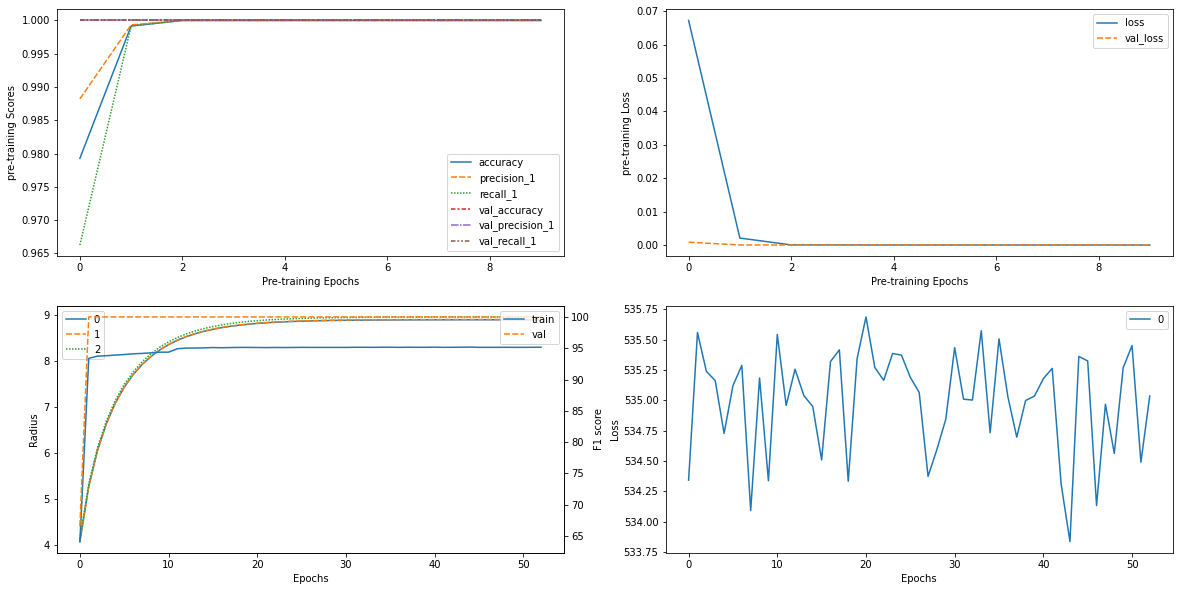

[[243   0   0   0]
 [  0 243   0   3]
 [  0   0 245   0]
 [  4   0   0 158]]
99.22
f1_weighted: 0.9921833573251249, f1_macro: 0.9910074846858343, f1_micro: 0.9921875, f_measure: {'Known': 99.5234, 'Open': 97.8328, 'F1-score': 99.1007}
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       243
           1       1.00      0.99      0.99       246
           2       1.00      1.00      1.00       245
           5       0.98      0.98      0.98       162

    accuracy                           0.99       896
   macro avg       0.99      0.99      0.99       896
weighted avg       0.99      0.99      0.99       896



In [3]:
comment="more pre-training helped, lets increase the wait also "
test_data, oset, hist = oset_train(ablation=2500,designated_ukc_cls=5,num_classes=3,embedding_size=12,
                             lr_rate=2.6, optimizer='adam',
pretrain_epochs=10, wait_patience=8, comment=comment)

In [ ]:
# pretraining should stop based on wait_patience